# Making a bacterial tree of different types to be reused for the different analysis

<body> Mainly using the ete2 python library to make phylogenetic trees. </body>

In [194]:
import os
import sys
import cPickle as pickle

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

def savePkl(db,pklFname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'    
    f = os.path.join(pklDir,pklFname)
    pickle.dump(db,open(f,'w'))
    return 

In [195]:
import time

accNbr_taxID_dict = loadPkl('accNbr_taxID.dict.pkl')
taxID_accNbr_dict = loadPkl('taxID_accNbr.dict.pkl')
cog_spList_dict = loadPkl('cog_spList.dict.pkl')
sp_cogList_dict = loadPkl('sp_cogList.dict.pkl')
cog_rankMembers_dict = loadPkl('cog_rankMembers.dict_dict.pkl')
sp_cogList = loadPkl('sp_cogList.dict.pkl')
org_cogList = loadPkl('org_cogList.dict.pkl')
genus_cogList = loadPkl('genus_cogList.dict.pkl')

print "Dictionaries loaded",time.ctime()

Dictionaries loaded Wed Dec 23 17:10:12 2015


In [94]:
# After collapsing the genome sequences to species level, I want to redo the same plots to map out the diversity
# of the sampling. 
# (a) Rank1(i.e. kingdom):[list of spp],... (b) COG1:[List of rank members (for Rank1)],[List of members (for Rank2)]
import os
import collections
from ete2 import NCBITaxa, AttrFace, TreeStyle
ncbi = NCBITaxa()

cog_rankMembers_dict = dict()

def make_RankDictionary(spList):
    rankName_memberList = collections.defaultdict(list)
    allSp = [item.replace('_',' ') for item in spList]
    name2taxid = ncbi.get_name_translator(allSp)
    for [taxid] in name2taxid.values():
        lineage = ncbi.get_lineage(taxid)
        taxid_rankName_dict = ncbi.get_rank(lineage)
        for taxid,rankName in taxid_rankName_dict.items():
            taxid2name = ncbi.get_taxid_translator([taxid])
            name = taxid2name[taxid]
            rankName_memberList[rankName].append(name)
    return rankName_memberList

for cog, spList in cog_spList_dict.items():
    rankName_memberList_dict = make_RankDictionary(spList)
    cog_rankMembers_dict[cog] = rankName_memberList_dict

savePkl(cog_rankMembers_dict,'cog_rankMembers.dict_dict.pkl')
print "COG : [Rank:List],.."


COG : [Rank:List],..


In [175]:
from ete2 import NCBITaxa, AttrFace, TreeStyle
ncbi = NCBITaxa()

def my_phyloTree(taxid_list):
    taxid2name = ncbi.get_taxid_translator(taxid_list)
    tree = ncbi.get_topology(taxid_list,rank_limit=None,collapse_subspecies=False)
    return tree

# custom layout: adds "rank" on top of branches, and sci_name as tip names
def my_layout(node):
    if getattr(node, "rank", None):
        rank_face = AttrFace("sci_name", fsize=12, fgcolor="#d55e00")
        node.add_face(rank_face, column=0, position="branch-top")
    if node.is_leaf():
        sciname_face = AttrFace("sci_name", fsize=12, fgcolor="#0072B2")
        node.add_face(sciname_face, column=0, position="branch-right")



In [147]:
from ete2 import NCBITaxa, AttrFace, TreeStyle
ncbi = NCBITaxa()

treeFig_dir = '/home/jaggu/research/projectFiles/operons/figures/treeFigures'
treeDir = '/home/jaggu/research/projectFiles/operons/tree_files'

allStrains_dir = '/home/jaggu/research/allGenomePttFiles'
allTaxID = list()
for path, dirnames, files in os.walk(allStrains_dir):
    for f in files:
        accNbr = os.path.split(f)[1][:-4]
        taxid = accNbr_taxID_dict.get(accNbr,None)
        allTaxID.append(taxid)
        
allTaxID = set(allTaxID)

ts = TreeStyle()
ts.layout_fn = my_layout
ts.show_leaf_name = False
ts.mode = "c"
#ts.arc_start = 0 # 0 degrees = 3 o'clock
#ts.arc_span = 180
tree = my_phyloTree(allTaxID)
#tree.show(tree_style=ts)
# Save Tree as figure
fname = 'allbacterial.tree.'
f = os.path.join(treeFig_dir,fname)
#tree.write(features=[],outfile=f,format=1)
tree.show(tree_style=ts)
#print "Rendered", f

In [63]:
# The idea is to get the statistics of the database I am working with; How many species in each category etc.
# The rank nomenclature is : 1. Root 2.Cellular organisms; 3.Superkingdom; 4.Phylum; 5.Class; 6.Order; 7.Family;
# 8.Genus; 9.Species; 10.Strains
# Will get the counts for ranks = Phylum, class, order, family, genus, species
import collections


def populateRANK(allTaxID_list):
    allRANK_dict = collections.defaultdict(list)
    for taxid in allTaxID_list:
        lineage = ncbi.get_lineage(taxid)
        rank_dict = ncbi.get_rank(lineage)
        for rankID,rankName in rank_dict.items():
            allRANK_dict[rankName].append(rankID)
    return allRANK_dict

def getAllTaxID():
    allStrains_dir = '/home/jaggu/research/allGenomePttFiles'
    allTaxID = list()
    for path, dirnames, files in os.walk(allStrains_dir):
        for f in files:
            accNbr = os.path.split(f)[1][:-4]
            taxid = accNbr_taxID_dict.get(accNbr,None)
            allTaxID.append(taxid)
    return allTaxID
       
def listMakeUp(idList):
    name_Counts_dict = collections.defaultdict(int)
    for taxid in idList:
        [name] = ncbi.translate_to_names([taxid])
        name_Counts_dict[name]+=1
    return name_Counts_dict

allTaxID = getAllTaxID()
allTaxID_list = list(set(allTaxID))
print "Number of organisms (unique Taxon ID) : ",len(allTaxID_list)
allRANK_dict = populateRANK(allTaxID_list)
rankNames = allRANK_dict.keys()

composition_dict = dict()
for rankName, allID in allRANK_dict.items():
    name_Counts_dict = listMakeUp(allID)
    composition_dict[rankName] = name_Counts_dict
    
allPhylum = allRANK_dict['phylum']
allClass = allRANK_dict['class']
allOrder = allRANK_dict['order']
allFamily = allRANK_dict['family']
allGenus = allRANK_dict['genus']
allSpecies = allRANK_dict['species']
print "Number of unique species",len(allSpecies)

print composition_dict['phylum']

Number of organisms (unique Taxon ID) :  2741
Number of unique species 2740
defaultdict(<type 'int'>, {u'Elusimicrobia': 2, u'Verrucomicrobia': 4, u'Chlamydiae': 107, u'Aquificae': 11, u'Actinobacteria': 278, u'Chlorobi': 11, u'Deferribacteres': 4, u'Nanoarchaeota': 1, u'Chrysiogenetes': 1, u'Cyanobacteria': 73, u'candidate division WWE3': 1, u'candidate division NC10': 1, u'Nitrospirae': 4, u'Dictyoglomi': 2, u'Cloacimonetes': 2, u'Thaumarchaeota': 6, u'Deinococcus-Thermus': 19, u'Proteobacteria': 1152, u'Acidobacteria': 8, u'Spirochaetes': 58, u'Candidatus Saccharibacteria': 2, u'Firmicutes': 582, u'Chloroflexi': 19, u'Planctomycetes': 7, u'Thermodesulfobacteria': 2, u'Fusobacteria': 8, u'Synergistetes': 5, u'Ignavibacteriae': 2, u'Crenarchaeota': 50, u'Korarchaeota': 1, u'Gemmatimonadetes': 1, u'Bacteroidetes': 98, u'Armatimonadetes': 1, u'Tenericutes': 86, u'Caldiserica': 1, u'Thermotogae': 15, u'Fibrobacteres': 1, u'Euryarchaeota': 106})


***
## Taxonomic Information of species considered and the distribution in the different ranks

### Mapping to taxonomic ranks - domain (superkingdom), phylum, class, order, family, genus, species for the graphs

<body> NOTE - The different mappings of the lineages for the different species are stratified into more groups namely - [u'superkingdom', u'tribe', u'no rank', u'subfamily', u'subgenus', u'family', u'species subgroup', u'subspecies', u'subclass', u'class', u'species group', u'phylum', u'suborder', u'superphylum', u'species', u'subphylum', u'genus', u'order'] <br/>

<body>
1. Total number of strains considered = 2775; <br />
2. Total number of genomes (including plasmids.i.e Total number of ptt files) = 5220; <br />
Distribution of genomes (after specie level collapse) is done at 
Rank - 
3. Superkingdom (Bacteria/Archae) = {u'Archaea': 99, u'Bacteria': 849})
4. Phylum distribution;
5. Class distribution;

/home/jaggu/research/projectFiles/operons/newFigures/sp_level_figures/sp-level.order_composition.bar.svg


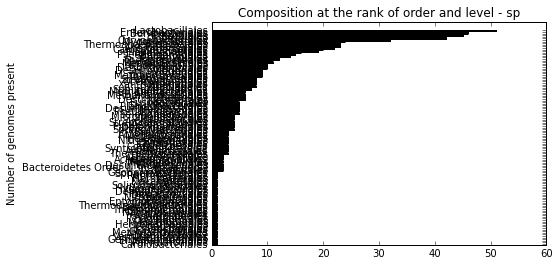

/home/jaggu/research/projectFiles/operons/newFigures/sp_level_figures/sp-level.superkingdom_compositon.pie.svg


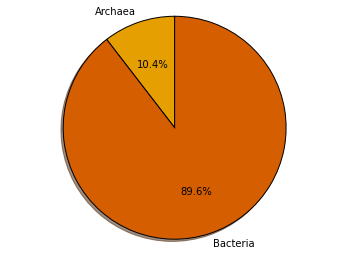

Composition of different ranks done


In [197]:
# Making new plots after the collapse of organisms (strains) to species level.
# Needs the sp_cogList.pkl for getting the list 
# Taxonomic ranks considered - superkingdom (domain), phylum, class, order, family, genus, species
# But the taxonomy id maps it to more stratified divisions namely - 

from __future__ import division
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter

def plot_domainPhylaDistribution(imgDir, rankName_memberList_dict,level='sp'):
     #Plotting the composition figure (a) pie chart for domain and (b) bar chart for phylum

    def getXYList(rank):
        rank_dict = getMembers(rank,rankName_memberList_dict)
        nameCount_list = list()
        for name, counts in rank_dict.items():
            nameCount_list.append((name,counts))
        nameCount_list = sorted(nameCount_list,key=itemgetter(1))
        xNames,yList = zip(*nameCount_list)
        xList = np.arange(len(xNames))
        return xList, yList, xNames

    # Bar chart highlighting the phyla represented
    #rank = 'phylum'
    #rank = 'class'
    rank = 'order'
    width = 0.5
    xList, yList, xNames = getXYList(rank)
    #new_yList = [item/sum(yList) for item in yList]
    rects = plt.barh(xList, yList, width, color='#0072B2')
    plt.yticks(xList+width,xNames)
    plt.ylabel('Number of genomes present')
    plt.title('Composition at the rank of '+rank + ' and level - '+level)
    #plt.ylim([0,1000])
    # Saving figure
    fname = level+'-level.'+rank+'_composition.bar.svg'
    f = os.path.join(imgDir,fname)
    print f
    plt.savefig(f,dpi=300)
    plt.show()

    # Pie chart highlighting the different superkingdoms represented
    rank = 'superkingdom'
    xList, yList, xNames = getXYList(rank)
    colorList = ['#E69F00','#D55E00']
    plt.pie(yList,labels=xNames,autopct='%1.1f%%',shadow=True,startangle=90,colors=colorList)
    plt.axis('equal')
    # Saving figure
    fname = level+'-level.superkingdom_compositon.pie.svg'
    f = os.path.join(imgDir,fname)
    print f
    plt.savefig(f,dpi=300)
    plt.show()
    return True

def listMakeUp(itemList):
    name_counts_dict = collections.defaultdict(int)
    for item in itemList:
        name_counts_dict[item]+=1
    return name_counts_dict

def make_RankDictionary(taxNameList,accNbr=False):
    rankName_memberList = collections.defaultdict(list)
    if accNbr: 
        allTaxID = [accNbr_taxID_dict.get(accNbr,None) for accNbr in taxNameList]
        taxid_list = [item for item in allTaxID if item]
        taxid2name = ncbi.get_taxid_translator(taxid_list)
        allSp = taxid2name.values()
    else:
        allSp = [item.replace('_',' ') for item in taxNameList if not item == ''] #IMPORTANT
    name2taxid = ncbi.get_name_translator(allSp)
    
    for taxid_asList in name2taxid.values():
        if len(taxid_asList) == 1: [taxid] = taxid_asList
        else: taxid = max(taxid_asList) #There are multiple taxid mapped
        lineage = ncbi.get_lineage(taxid)
        taxid_rankName_dict = ncbi.get_rank(lineage)
        for taxid,rankName in taxid_rankName_dict.items():
            taxid2name = ncbi.get_taxid_translator([taxid])
            name = taxid2name[taxid]
            rankName_memberList[rankName].append(name)
    return rankName_memberList

def getMembers(rank,rankName_memberList_dict):
    member_counts = listMakeUp(rankName_memberList_dict[rank])
    return member_counts

def org_levelDistribution():
    allOrgs_accNbr = [item[1] for item in org_cogList.keys()]
    org_rankName_memberList_dict = make_RankDictionary(allOrgs_accNbr,accNbr=True)
    print org_rankName_memberList_dict.keys()
    org_imgDir = '/home/jaggu/research/projectFiles/operons/newFigures/org_level_figures'
    if not os.path.exists(org_imgDir): os.makedirs(org_imgDir)
    plot_domainPhylaDistribution(org_imgDir, org_rankName_memberList_dict,level='org')

def sp_levelDistribution():
    allSpecies = sp_cogList.keys()
    sp_rankName_memberList_dict = make_RankDictionary(allSpecies)
    sp_imgDir = '/home/jaggu/research/projectFiles/operons/newFigures/sp_level_figures'
    if not os.path.exists(sp_imgDir): os.makedirs(sp_imgDir)
    plot_domainPhylaDistribution(sp_imgDir, sp_rankName_memberList_dict,level='sp')

def genus_levelDistribution():
    allGenus = genus_cogList.keys()
    genus_rankName_memberList_dict = make_RankDictionary(allGenus)
    genus_imgDir = '/home/jaggu/research/projectFiles/operons/newFigures/genus_level_figures'
    if not os.path.exists(genus_imgDir): os.makedirs(genus_imgDir)
    plot_domainPhylaDistribution(genus_imgDir, genus_rankName_memberList_dict,level='sp')

#genus_levelDistribution()
sp_levelDistribution()
#org_levelDistribution()

print "Composition of different ranks done"

In [164]:
lineage = ncbi.get_lineage(404)
print lineage

[1, 131567, 2, 1224, 28216, 206350, 32011, 404]


[0.004223864836325237, 0.012671594508975714, 0.007391763463569166, 0.11087645195353749, 0.010559662090813094, 0.004223864836325237, 0.0010559662090813093, 0.009503695881731784, 0.0010559662090813093, 0.0021119324181626186, 0.0010559662090813093, 0.0010559662090813093, 0.012671594508975714, 0.0010559662090813093, 0.005279831045406547, 0.026399155227032733, 0.17845828933474128, 0.0021119324181626186, 0.009503695881731784, 0.005279831045406547, 0.0010559662090813093, 0.005279831045406547, 0.0031678986272439284, 0.030623020063357972, 0.0010559662090813093, 0.3938753959873284, 0.046462513199577615, 0.0010559662090813093, 0.028511087645195353, 0.011615628299894404, 0.0010559662090813093, 0.06969376979936642]
/home/jaggu/research/projectFiles/operons/sp_level_figures/phylum_composition.asPerc.bar.svg


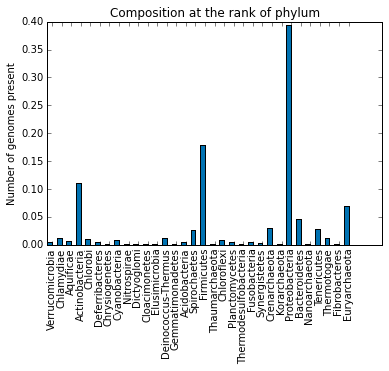

/home/jaggu/research/projectFiles/operons/sp_level_figures/superkingdom_compositon.pie.svg


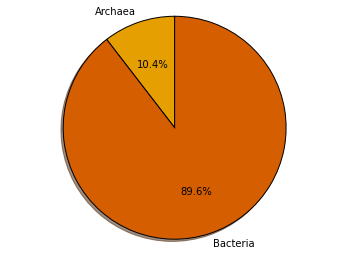

Composition dictionary keys :  [u'superkingdom', u'tribe', u'no rank', u'genus', u'subgenus', u'family', u'species subgroup', u'subphylum', u'subclass', u'species', u'class', u'species group', u'phylum', u'suborder', u'superphylum', u'subspecies', u'subfamily', u'order']
/home/jaggu/research/projectFiles/operons/figures/phylum_composition.bar.svg


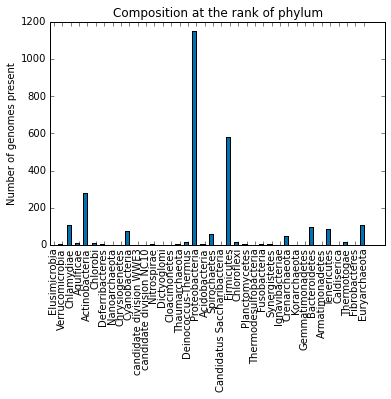

/home/jaggu/research/projectFiles/operons/figures/superkingdom_compositon.pie.svg


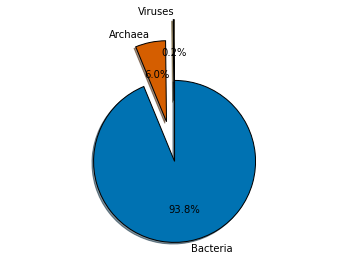

In [223]:
# Composition dictionary is made; Now I have to plot it as appropriate bar or pie chart
imgDir = '/home/jaggu/research/projectFiles/operons/figures'

#% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

print "Composition dictionary keys : ",composition_dict.keys()

def getXYList(rank):
    nameCount_list = list()
    name_counts_dict = composition_dict[rank]
    for name, counts in name_counts_dict.items():
        nameCount_list.append((name,counts))
    xNames,yList = zip(*nameCount_list)
    xList = np.arange(len(xNames))
    return xList, yList, xNames

rank = 'phylum'
width = 0.5
xList, yList, xNames = getXYList(rank)
rects = plt.bar(xList, yList, width, color='#0072B2')
plt.xticks(xList+width,xNames,rotation='vertical')
plt.ylabel('Number of genomes present')
plt.title('Composition at the rank of '+rank)
# Saving figure
fname = 'phylum_composition.bar.svg'
f = os.path.join(imgDir,fname)
print f
plt.savefig(f,dpi=300)
plt.show()

# Pie chart highlighting the different superkingdoms represented
rank = 'superkingdom'
xList, yList, xNames = getXYList(rank)
explode = (0.75, 0.5,0)  # only "explode" the 2nd slice (i.e. 'Hogs')
colorList = ['#E69F00','#D55E00','#0072B2']
plt.pie(yList,explode=explode,labels=xNames,autopct='%1.1f%%',shadow=True,startangle=90,colors=colorList)
plt.axis('equal')
# Saving figure
fname = 'superkingdom_compositon.pie.svg'
f = os.path.join(imgDir,fname)
print f
plt.savefig(f,dpi=300)
plt.show()


Keys in allRANK_dict [u'superkingdom', u'tribe', u'no rank', u'subfamily', u'subgenus', u'suborder', u'family', u'species subgroup', u'subclass', u'order', u'species group', u'phylum', u'subspecies', u'superphylum', u'species', u'subphylum', u'genus', u'class']
Number of organisms (unique Taxon ID) :  2741
[0 1] [u'Lactobacillales', u'Bacillales'] [221, 203]
424
/home/jaggu/research/projectFiles/operons/figures/Bacilli_composition.bar.svg


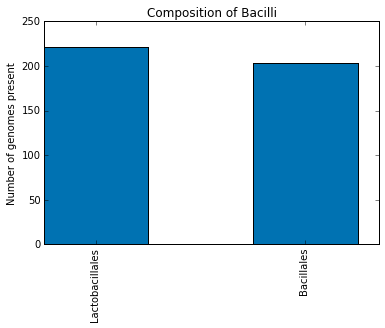

In [222]:
# Plotting a tree of the phylum - proteobacteria; Getting the taxon ID of all the species from the given phylum
treeFig_dir = '/home/jaggu/research/projectFiles/operons/figures/treeFigures'
treeDir = '/home/jaggu/research/projectFiles/operons/treeFiles'

print "Keys in allRANK_dict",allRANK_dict.keys()

def drawTree(tree):
    # Tree manipulation
    ts = TreeStyle()
    ts.layout_fn = my_layout
    ts.show_leaf_name = False
    ts.mode = "c"

    fname = 'proteobacteria.tree.newick'
    f = os.path.join(treeDir,fname)
    tree.write(outfile=f,format=1)
    print "Written",f

    #tree.render("%%inline",tree_style = ts)    
    #tree.show(tree_style=ts)

def get_taxonID_fromRank(rankID,allTaxID_list):
    filtered_list = list()
    for taxid in allTaxID_list:
        lineage = ncbi.get_lineage(taxid)
        if rankID in lineage:
            filtered_list.append(taxid)
    return filtered_list

def listMakeUp(idList):
    name_Counts_dict = collections.defaultdict(int)
    for taxid in idList:
        [name] = ncbi.translate_to_names([taxid])
        name_Counts_dict[name]+=1
    return name_Counts_dict

allTaxID = getAllTaxID()
allTaxID_list = list(set(allTaxID))
print "Number of organisms (unique Taxon ID) : ",len(allTaxID_list)

#print allRANK_dict['phylum']
def getComposition(name):
    xNames = list()
    yList = list()
    name2taxid = ncbi.get_name_translator([name])
    [rankID] = name2taxid[name]
    filtered_taxonList = get_taxonID_fromRank(rankID,allTaxID_list)
    tree = my_phyloTree(filtered_taxonList)
    for node in tree.get_children():
        taxid = int(node.name)
        [name] = ncbi.translate_to_names([taxid])
        xNames.append(name)
        yList.append(len(node.get_leaves()))
    xList = np.arange(len(xNames))
    return xList, yList, xNames

#name = 'Proteobacteria'
#name = 'Firmicutes'
name = 'Bacilli'
#name = 'Gammaproteobacteria'
#name = 'Enterobacteriaceae'
#name = 'Escherichia'
xList, yList, xNames = getComposition(name)
print xList, xNames, yList

print sum(yList)

width = 0.5
rects = plt.bar(xList, yList, width, color='#0072B2')
plt.xticks(xList+0.25,xNames,rotation='vertical')
plt.ylabel('Number of genomes present')
plt.title('Composition of '+name)
# Saving figure
fname = name + '_composition.bar.svg'
f = os.path.join(imgDir,fname)
print f
plt.savefig(f,dpi=300)
plt.show()

In [40]:
allTaxID_list = list(allTaxID)
type(allTaxID_list)
taxid = allTaxID_list[0]
lineage = ncbi.get_lineage(1420014)
print lineage
lineage = ncbi.get_lineage(taxid)
print lineage

print ncbi.translate_to_names([1239])
print ncbi.translate_to_names(lineage)
db = ncbi.get_rank(lineage)

for rankid,rankname in db.items():
    if rankname == 'phylum':
        print rankid, rankname

[1, 131567, 2, 1224, 1236, 91347, 543, 561, 562, 83333, 1420014]
[1, 131567, 2, 1239, 186801, 186802, 186807, 471826, 471827, 477974]
[u'Firmicutes']
[u'root', u'cellular organisms', u'Bacteria', u'Firmicutes', u'Clostridia', u'Clostridiales', u'Peptococcaceae', u'Candidatus Desulforudis', u'Candidatus Desulforudis audaxviator', u'Candidatus Desulforudis audaxviator MP104C']
1239 phylum


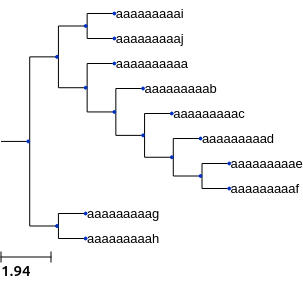

In [70]:
from ete2 import Tree, TreeStyle

t = Tree()
t.populate(10)
ts = TreeStyle()
ts.show_leaf_name = True
ts.branch_vertical_margin = 10 # 10 pixels between adjacent branches
t.render("%%inline",tree_style=ts)